In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.simplefilter("ignore", UserWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

# BIRDS SOUND DATASET

In [2]:
data=pd.read_csv('/kaggle/input/sound-of-114-species-of-birds-till-2022/Birds Voice.csv')
data.head()

,common_name,scientific_name,recordist_name,recording_length,Date,TYPE,xc_id,Time,Country,Download_link
0,Common Ostrich,Struthio camelus australis,Frank Lambert,0:53,2019-10-30,call,XC516153,08:05,South Africa,https://xeno-canto.org/516153/download
1,Common Ostrich,Struthio camelus,Jeremy Hegge,0:26,2014-11-20,call,XC208209,04:00,South Africa,https://xeno-canto.org/208209/download
2,Common Ostrich,Struthio camelus,Jeremy Hegge,0:04,2014-11-21,call,XC208128,06:00,South Africa,https://xeno-canto.org/208128/download
3,Common Ostrich,Struthio camelus,Derek Solomon,0:11,2010-02-09,call,XC46725,07:00,South Africa,https://xeno-canto.org/46725/download
4,Common Ostrich,Struthio camelus,Morioka Zoological Park ZOOMO,1:47,2021-09-06,"voice during egg laying, zoo collection",XC675445,17:00,Japan,https://xeno-canto.org/675445/download


## Question 1 Explore Dataset

In [3]:
data.shape

(2161, 10)

In [4]:
# Create some time features
data['year'] = data['Date'].apply(lambda x: x.split('-')[0])
data['month'] = data['Date'].apply(lambda x: x.split('-')[1])
data['day_of_month'] = data['Date'].apply(lambda x: x.split('-')[2])

print("There are {:,} unique bird species in the dataset.".format(len(data['common_name'].unique())))


There are 114 unique bird species in the dataset.


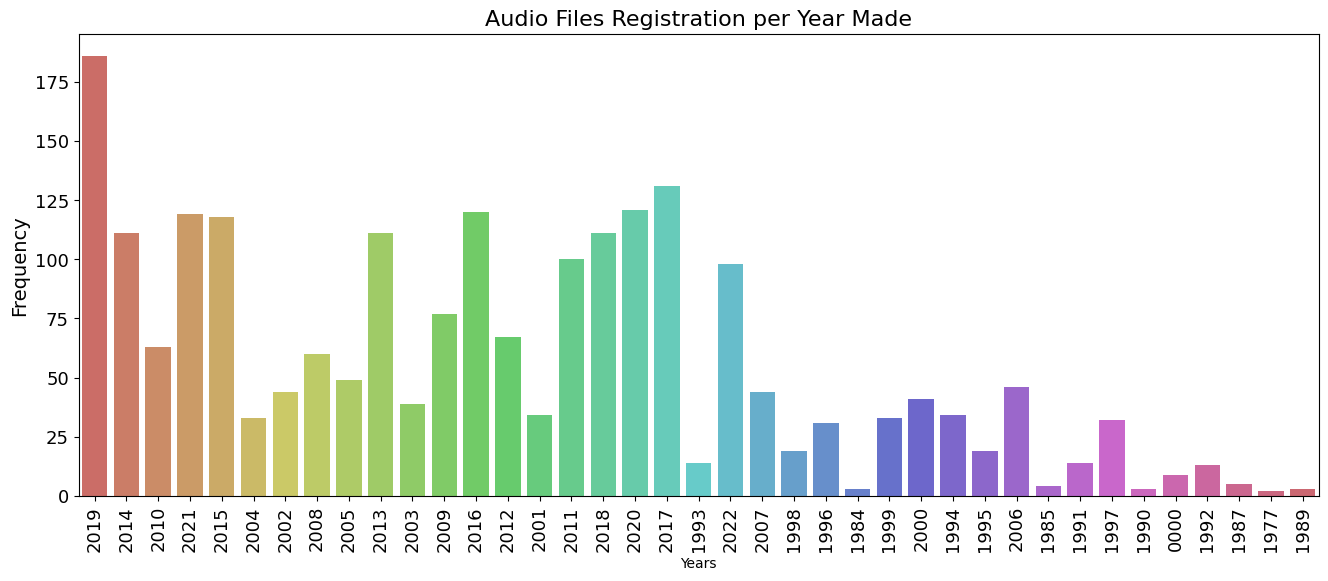

In [5]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x=data['year'], palette="hls")

plt.title("Audio Files Registration per Year Made", fontsize=16)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=14)

plt.xlabel("Years");

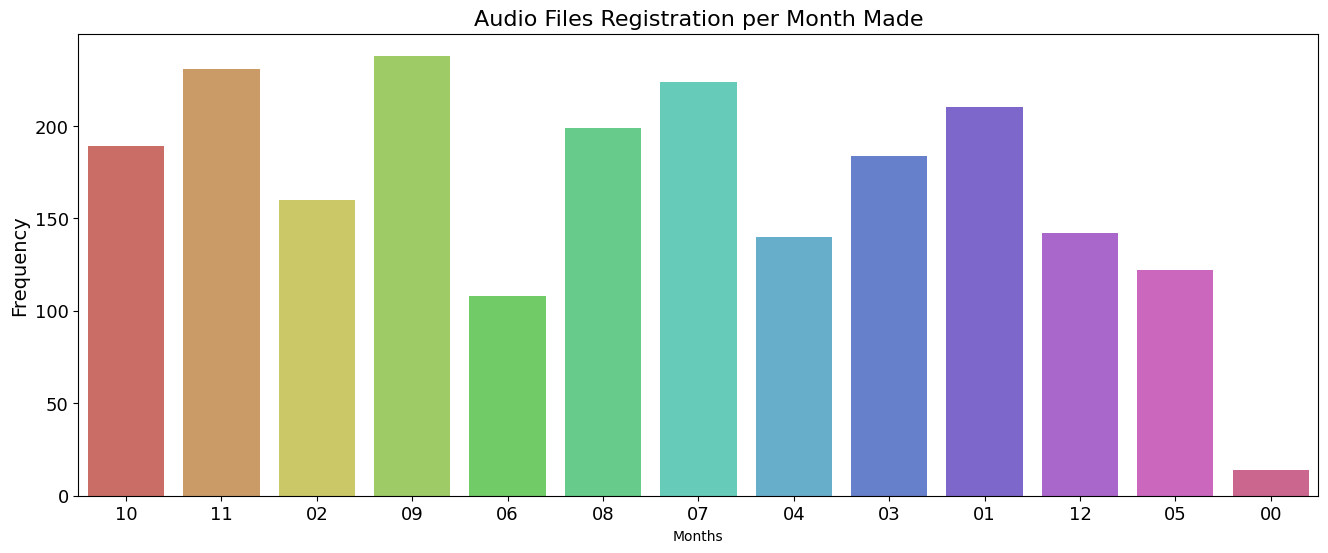

In [6]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x=data['month'], palette="hls")

plt.title("Audio Files Registration per Month Made", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Months");

In [7]:
data.isnull().sum()

common_name          0
scientific_name      0
recordist_name       0
recording_length     0
Date                 0
TYPE                31
xc_id                0
Time                 0
Country              0
Download_link        0
year                 0
month                0
day_of_month         0
dtype: int64

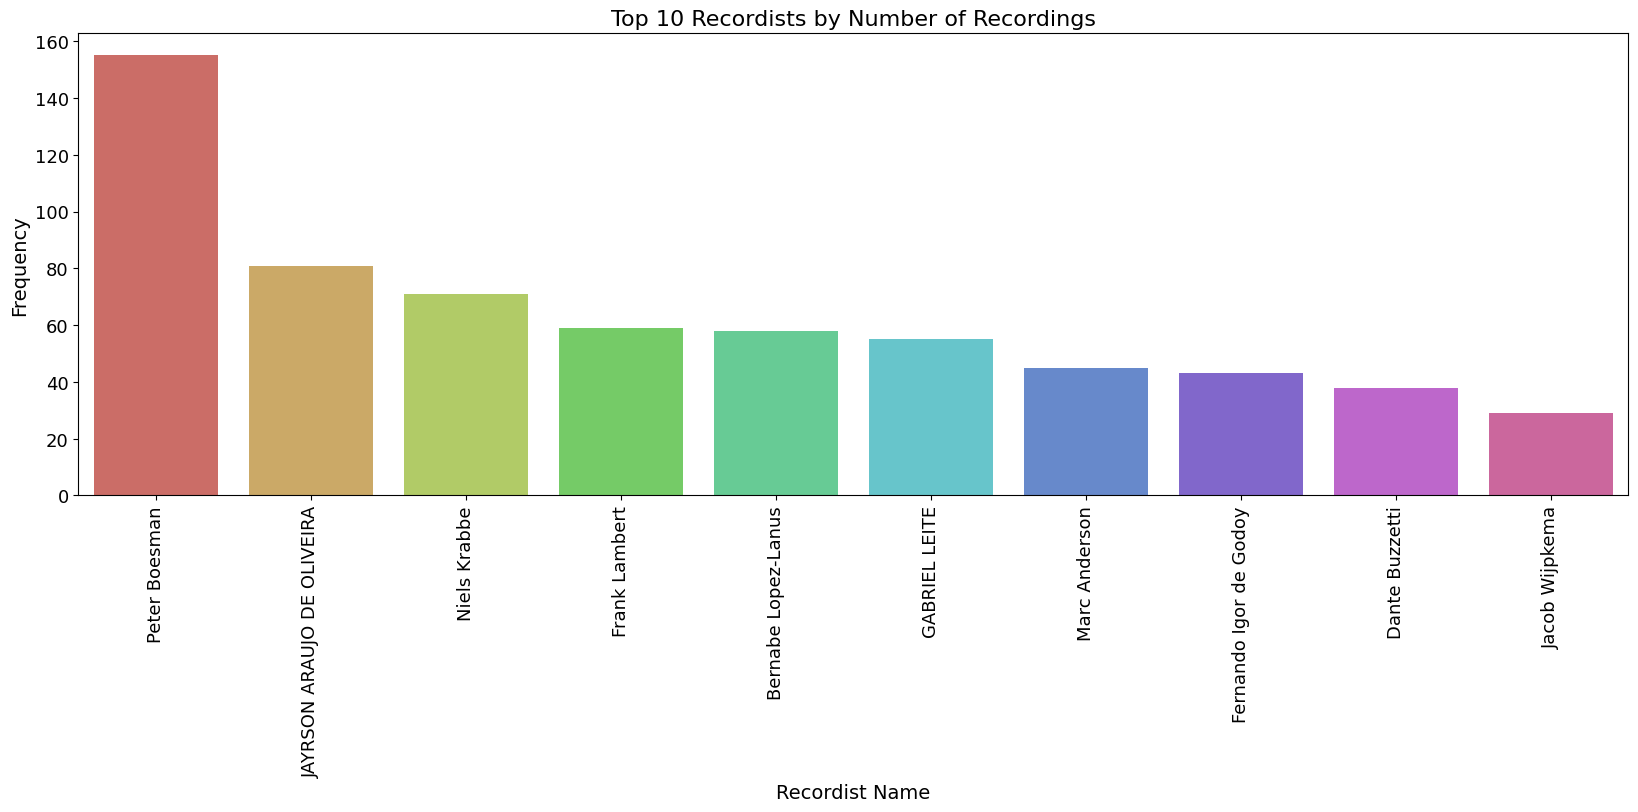

In [8]:

plt.figure(figsize=(20, 6))
plt.xticks(rotation=90, fontsize=13)

ax = sns.countplot(
    x="recordist_name", 
    data=data, 
    palette='hls', 
    order=data['recordist_name'].value_counts().head(10).index  # Correct ordering
)

plt.title("Top 10 Recordists by Number of Recordings", fontsize=16)
plt.xlabel("Recordist Name", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)

plt.show()

## Question 2  Provide some samples of Spectrogram of sound signals

In [9]:
def plot_spectrogram(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title("Mel Spectrogram")
    plt.show()

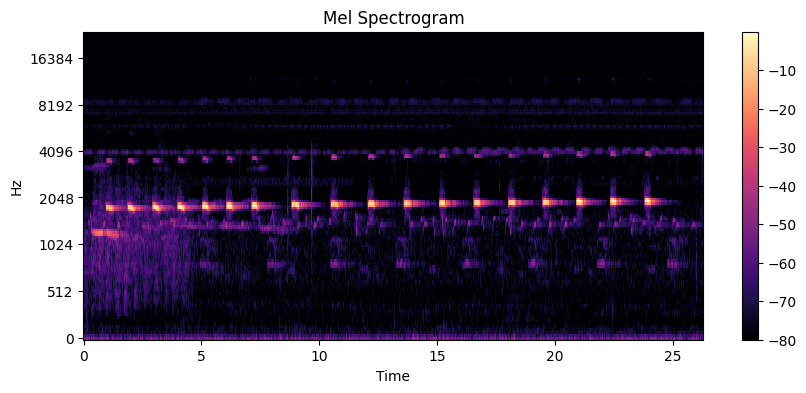

In [10]:
plot_spectrogram("/kaggle/input/sound-of-114-species-of-birds-till-2022/Voice of Birds/Voice of Birds/Bartletts Tinamou_sound/Bartletts Tinamou11.mp3")

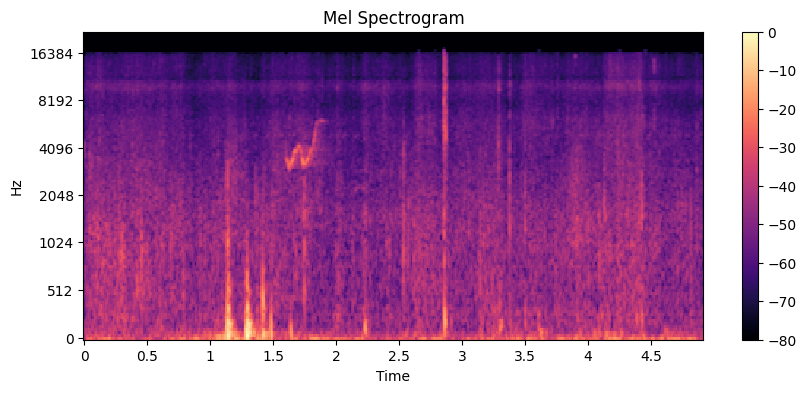

In [11]:
plot_spectrogram("/kaggle/input/sound-of-114-species-of-birds-till-2022/Voice of Birds/Voice of Birds/Andean Tinamou_sound/Andean Tinamou15.mp3")

## Quesrion 3 Provide some samples of MFCC of sound signals.

In [12]:
# Function to plot MFCCs
def plot_mfcc(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', cmap='coolwarm')
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()


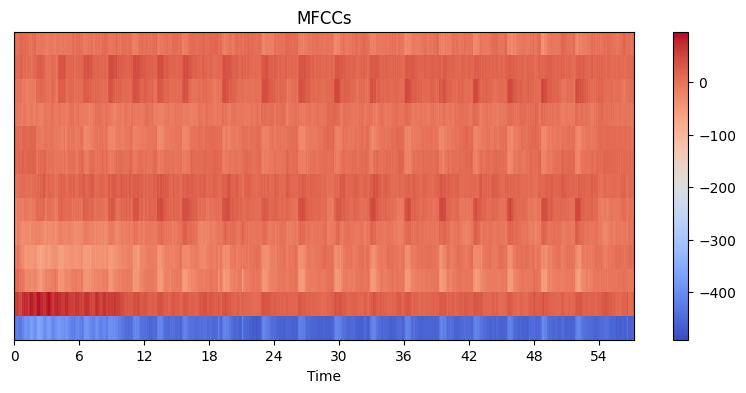

In [13]:
plot_mfcc("/kaggle/input/sound-of-114-species-of-birds-till-2022/Voice of Birds/Voice of Birds/Bartletts Tinamou_sound/Bartletts Tinamou11.mp3")

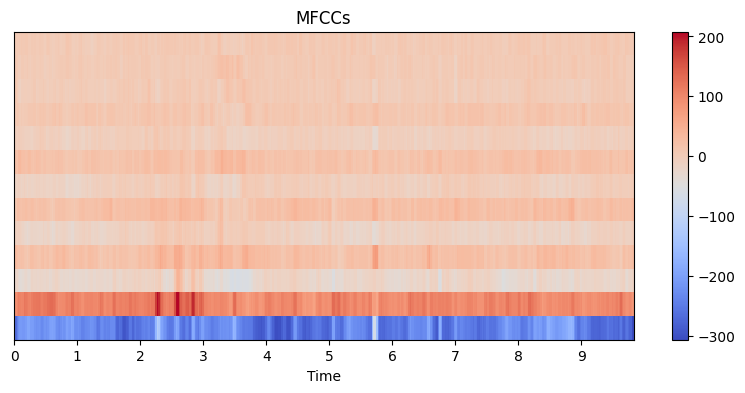

In [14]:
plot_mfcc("/kaggle/input/sound-of-114-species-of-birds-till-2022/Voice of Birds/Voice of Birds/Andean Tinamou_sound/Andean Tinamou15.mp3")

In [15]:
data.columns

Index(['common_name', 'scientific_name', 'recordist_name', 'recording_length',
       'Date', 'TYPE', 'xc_id', 'Time', 'Country', 'Download_link', 'year',
       'month', 'day_of_month'],
      dtype='object')

## Question 4 Provide three different models and compare performance

In [16]:
def load_data():
    file_path = []  
    labels = []  


    for file in Path('/kaggle/input/sound-of-114-species-of-birds-till-2022/Voice of Birds/Voice of Birds/').glob('*/*.mp3'):
        label = str(file).split('/')[-2].split('_')[0]

        file_path.append(file)
        labels.append(label)
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels) 
    dd = pd.DataFrame()

    dd['file'] = file_path
    dd['Bird']=labels
    dd['label'] = encoded_labels

    return dd

In [17]:
df = load_data()  
df.sample(5)

,file,Bird,label
1700,/kaggle/input/sound-of-114-species-of-birds-ti...,West Mexican Chachalaca,106
6,/kaggle/input/sound-of-114-species-of-birds-ti...,Micronesian Megapode,58
1250,/kaggle/input/sound-of-114-species-of-birds-ti...,Tawny-breasted Tinamou,97
1870,/kaggle/input/sound-of-114-species-of-birds-ti...,Spotted Nothura,92
775,/kaggle/input/sound-of-114-species-of-birds-ti...,White-throated Tinamou,111


In [18]:
max(df['label'])

113

In [19]:
label_counts = df["label"].value_counts()

valid_labels = label_counts[label_counts >= 25].index

df = df[df["label"].isin(valid_labels)].reset_index(drop=True)

label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(valid_labels))}
df["label"] = df["label"].map(label_mapping) 
print("Updated label mapping:", label_mapping)  


Updated label mapping: {0: 0, 1: 1, 2: 2, 3: 3, 5: 4, 7: 5, 12: 6, 14: 7, 15: 8, 16: 9, 17: 10, 19: 11, 20: 12, 23: 13, 26: 14, 28: 15, 30: 16, 33: 17, 34: 18, 36: 19, 41: 20, 43: 21, 44: 22, 46: 23, 51: 24, 53: 25, 65: 26, 67: 27, 70: 28, 75: 29, 77: 30, 78: 31, 79: 32, 80: 33, 82: 34, 84: 35, 85: 36, 86: 37, 90: 38, 91: 39, 92: 40, 96: 41, 97: 42, 99: 43, 102: 44, 104: 45, 106: 46, 108: 47, 111: 48, 113: 49}


In [20]:
from tqdm import tqdm

# Function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=20):
    try:
        y, sr = librosa.load(file_path)  
        mfcc = librosa.feature.mfcc(y=y,  n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)  
        return mfcc_mean
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  

data_list = []

# Process each audio file
for _, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row["file"]  
    bird_name = row["Bird"]  
    label = row["label"]  

    mfcc_features = extract_mfcc(file_path)
    
    if mfcc_features is not None:
        data_list.append((*mfcc_features, bird_name, label))

# Create a new DataFrame
mfcc_columns = [f"mfcc_{i}" for i in range(20)] + ["Bird", "label"]
df_mfcc = pd.DataFrame(data_list, columns=mfcc_columns)

# Save the MFCC dataset as a CSV file
df_mfcc.to_csv("bird_sound_mfcc.csv", index=False)

print("MFCC dataset saved as bird_sound_mfcc.csv")
print(df_mfcc.head()) 

 85%|████████▍ | 1261/1490 [03:54<00:22, 10.07it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 1490/1490 [04:43<00:00,  5.26it/s]


MFCC dataset saved as bird_sound_mfcc.csv
       mfcc_0     mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5  \
0 -402.454163 -72.380852  -3.890645  80.261948 -40.429264   4.448273   
1 -346.962769 -27.038431 -74.460121   9.296798 -24.707138  12.009462   
2 -521.461060  77.230629 -30.147156   6.309694   3.189224 -12.770516   
3 -375.550568  56.298115  48.706661  46.140827  14.893952  38.714916   
4 -521.461060  77.230629 -30.147156   6.309694   3.189224 -12.770516   

      mfcc_6     mfcc_7     mfcc_8     mfcc_9  ...    mfcc_12    mfcc_13  \
0  -2.869878  -7.283318  -6.822911   1.809999  ... -19.523636  15.093065   
1 -28.025753  -5.778861  -8.067972  12.261641  ...  -2.656115  -1.839422   
2  -0.361278 -18.360550 -18.169085   3.259609  ... -12.116795   1.361606   
3  -7.019715  20.173199  -2.913657  12.469887  ...  21.563004  -1.691527   
4  -0.361278 -18.360550 -18.169085   3.259609  ... -12.116795   1.361606   

     mfcc_14    mfcc_15   mfcc_16    mfcc_17    mfcc_18    mfcc_19  

In [21]:
df_mfcc.head()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,Bird,label
0,-402.454163,-72.380852,-3.890645,80.261948,-40.429264,4.448273,-2.869878,-7.283318,-6.822911,1.809999,...,-19.523636,15.093065,-4.659661,-9.282938,3.310895,10.807809,-8.889758,2.308549,Cinereous Tinamou,14
1,-346.962769,-27.038431,-74.460121,9.296798,-24.707138,12.009462,-28.025753,-5.778861,-8.067972,12.261641,...,-2.656115,-1.839422,-2.927645,-9.296164,5.511785,4.213373,2.875708,-6.703529,Cinereous Tinamou,14
2,-521.461060,77.230629,-30.147156,6.309694,3.189224,-12.770516,-0.361278,-18.360550,-18.169085,3.259609,...,-12.116795,1.361606,-9.493540,-23.138828,-4.006065,5.412633,-16.027281,-12.061152,Cinereous Tinamou,14
3,-375.550568,56.298115,48.706661,46.140827,14.893952,38.714916,-7.019715,20.173199,-2.913657,12.469887,...,21.563004,-1.691527,14.818547,2.759990,-0.935970,9.496833,6.646720,6.692846,Cinereous Tinamou,14
4,-521.461060,77.230629,-30.147156,6.309694,3.189224,-12.770516,-0.361278,-18.360550,-18.169085,3.259609,...,-12.116795,1.361606,-9.493540,-23.138828,-4.006065,5.412633,-16.027281,-12.061152,Cinereous Tinamou,14


In [22]:
df_mfcc.isnull().sum()

mfcc_0     0
mfcc_1     0
mfcc_2     0
mfcc_3     0
mfcc_4     0
mfcc_5     0
mfcc_6     0
mfcc_7     0
mfcc_8     0
mfcc_9     0
mfcc_10    0
mfcc_11    0
mfcc_12    0
mfcc_13    0
mfcc_14    0
mfcc_15    0
mfcc_16    0
mfcc_17    0
mfcc_18    0
mfcc_19    0
Bird       0
label      0
dtype: int64

In [23]:
df_mfcc["label"].nunique()

50

In [24]:


# Extract Features (MFCC values) and Labels
feature_columns = [col for col in df_mfcc.columns if col.startswith("mfcc_")]
X = df_mfcc[feature_columns].values  
y = df_mfcc["label"].values 



In [25]:
y.shape

(1490,)

In [26]:

# Convert to PyTorch Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

In [27]:
unique_values = torch.unique(y_train)
unique_values.shape[0]


50

In [28]:
class BirdSoundDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [29]:
train_dataset = BirdSoundDataset(X_train, y_train)
test_dataset = BirdSoundDataset(X_test, y_test)

In [30]:
train_dataset[0]

(tensor([-404.5674,   88.4300,  -32.3085,   39.9422,  -19.5925,   10.4843,
           -0.6261,    0.5076,  -12.9698,    1.6952,    3.3602,  -11.5862,
           11.0102,   -5.3577,   -3.8477,   -3.5723,    5.6080,   -2.8800,
            0.8500,    3.6349]),
 tensor(44))

In [31]:
df.to_csv("dataset.csv",index=False)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [33]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch size: {data.size()}")
    print(target.size(),target[0])
    break 

Batch size: torch.Size([32, 20])
torch.Size([32]) tensor(5)


In [34]:
len(train_loader)

38

In [35]:
## Simple RNN model

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(20, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,50)
        )
    
    def forward(self, x):
        return self.fc(x)

In [36]:
class CNN(nn.Module):
    def __init__(self, n_mfcc=20, num_classes=50):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
          
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
    
        )
      
        final_length = n_mfcc // 4  
        self.fc = nn.Linear(64 * final_length, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.conv(x)    
        x = x.view(x.size(0), -1)  
        return self.fc(x)


In [37]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=128, num_classes=50):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        x = x.unsqueeze(1) 
        
        _, (h_n, _) = self.lstm(x)
        
        h = h_n[-1] 

        out = self.fc(h) 
        return out


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [39]:
model=SimpleNN()
model.to(device)
epochs=50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:


from tqdm import tqdm

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for x_batch, y_batch in progress_bar:
        # Move data to GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update loss
        running_loss += loss.detach().item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")



Epoch 1/50: 100%|██████████| 38/38 [00:00<00:00, 87.42it/s]


Epoch 1/50, Loss: 4.0418


Epoch 2/50: 100%|██████████| 38/38 [00:00<00:00, 525.09it/s]


Epoch 2/50, Loss: 3.6304


Epoch 3/50: 100%|██████████| 38/38 [00:00<00:00, 456.55it/s]


Epoch 3/50, Loss: 3.3412


Epoch 4/50: 100%|██████████| 38/38 [00:00<00:00, 538.59it/s]


Epoch 4/50, Loss: 3.0410


Epoch 5/50: 100%|██████████| 38/38 [00:00<00:00, 552.39it/s]


Epoch 5/50, Loss: 2.7540


Epoch 6/50: 100%|██████████| 38/38 [00:00<00:00, 541.03it/s]


Epoch 6/50, Loss: 2.4596


Epoch 7/50: 100%|██████████| 38/38 [00:00<00:00, 535.07it/s]


Epoch 7/50, Loss: 2.2356


Epoch 8/50: 100%|██████████| 38/38 [00:00<00:00, 499.45it/s]


Epoch 8/50, Loss: 2.0293


Epoch 9/50: 100%|██████████| 38/38 [00:00<00:00, 528.92it/s]


Epoch 9/50, Loss: 1.9015


Epoch 10/50: 100%|██████████| 38/38 [00:00<00:00, 548.43it/s]


Epoch 10/50, Loss: 1.6361


Epoch 11/50: 100%|██████████| 38/38 [00:00<00:00, 530.97it/s]


Epoch 11/50, Loss: 1.5439


Epoch 12/50: 100%|██████████| 38/38 [00:00<00:00, 536.87it/s]


Epoch 12/50, Loss: 1.3705


Epoch 13/50: 100%|██████████| 38/38 [00:00<00:00, 557.35it/s]


Epoch 13/50, Loss: 1.2646


Epoch 14/50: 100%|██████████| 38/38 [00:00<00:00, 550.18it/s]


Epoch 14/50, Loss: 1.1692


Epoch 15/50: 100%|██████████| 38/38 [00:00<00:00, 539.68it/s]


Epoch 15/50, Loss: 1.0742


Epoch 16/50: 100%|██████████| 38/38 [00:00<00:00, 527.18it/s]


Epoch 16/50, Loss: 0.9458


Epoch 17/50: 100%|██████████| 38/38 [00:00<00:00, 528.51it/s]


Epoch 17/50, Loss: 0.8794


Epoch 18/50: 100%|██████████| 38/38 [00:00<00:00, 528.05it/s]


Epoch 18/50, Loss: 0.7855


Epoch 19/50: 100%|██████████| 38/38 [00:00<00:00, 577.32it/s]


Epoch 19/50, Loss: 0.6938


Epoch 20/50: 100%|██████████| 38/38 [00:00<00:00, 569.10it/s]


Epoch 20/50, Loss: 0.6060


Epoch 21/50: 100%|██████████| 38/38 [00:00<00:00, 565.32it/s]


Epoch 21/50, Loss: 0.5314


Epoch 22/50: 100%|██████████| 38/38 [00:00<00:00, 548.50it/s]


Epoch 22/50, Loss: 0.5589


Epoch 23/50: 100%|██████████| 38/38 [00:00<00:00, 552.52it/s]


Epoch 23/50, Loss: 0.4470


Epoch 24/50: 100%|██████████| 38/38 [00:00<00:00, 542.30it/s]


Epoch 24/50, Loss: 0.4136


Epoch 25/50: 100%|██████████| 38/38 [00:00<00:00, 533.50it/s]


Epoch 25/50, Loss: 0.3786


Epoch 26/50: 100%|██████████| 38/38 [00:00<00:00, 550.99it/s]


Epoch 26/50, Loss: 0.3521


Epoch 27/50: 100%|██████████| 38/38 [00:00<00:00, 558.60it/s]


Epoch 27/50, Loss: 0.2992


Epoch 28/50: 100%|██████████| 38/38 [00:00<00:00, 549.90it/s]


Epoch 28/50, Loss: 0.2652


Epoch 29/50: 100%|██████████| 38/38 [00:00<00:00, 557.06it/s]


Epoch 29/50, Loss: 0.2418


Epoch 30/50: 100%|██████████| 38/38 [00:00<00:00, 548.28it/s]


Epoch 30/50, Loss: 0.2210


Epoch 31/50: 100%|██████████| 38/38 [00:00<00:00, 543.20it/s]


Epoch 31/50, Loss: 0.2286


Epoch 32/50: 100%|██████████| 38/38 [00:00<00:00, 558.80it/s]


Epoch 32/50, Loss: 0.1976


Epoch 33/50: 100%|██████████| 38/38 [00:00<00:00, 575.64it/s]


Epoch 33/50, Loss: 0.2092


Epoch 34/50: 100%|██████████| 38/38 [00:00<00:00, 583.25it/s]


Epoch 34/50, Loss: 0.1870


Epoch 35/50: 100%|██████████| 38/38 [00:00<00:00, 578.97it/s]


Epoch 35/50, Loss: 0.1931


Epoch 36/50: 100%|██████████| 38/38 [00:00<00:00, 551.37it/s]


Epoch 36/50, Loss: 0.1606


Epoch 37/50: 100%|██████████| 38/38 [00:00<00:00, 547.96it/s]


Epoch 37/50, Loss: 0.2205


Epoch 38/50: 100%|██████████| 38/38 [00:00<00:00, 545.64it/s]


Epoch 38/50, Loss: 0.2211


Epoch 39/50: 100%|██████████| 38/38 [00:00<00:00, 553.97it/s]


Epoch 39/50, Loss: 0.1694


Epoch 40/50: 100%|██████████| 38/38 [00:00<00:00, 541.09it/s]


Epoch 40/50, Loss: 0.1477


Epoch 41/50: 100%|██████████| 38/38 [00:00<00:00, 535.85it/s]


Epoch 41/50, Loss: 0.1255


Epoch 42/50: 100%|██████████| 38/38 [00:00<00:00, 553.11it/s]


Epoch 42/50, Loss: 0.1319


Epoch 43/50: 100%|██████████| 38/38 [00:00<00:00, 540.71it/s]


Epoch 43/50, Loss: 0.1167


Epoch 44/50: 100%|██████████| 38/38 [00:00<00:00, 565.86it/s]


Epoch 44/50, Loss: 0.1015


Epoch 45/50: 100%|██████████| 38/38 [00:00<00:00, 550.88it/s]


Epoch 45/50, Loss: 0.0945


Epoch 46/50: 100%|██████████| 38/38 [00:00<00:00, 559.63it/s]


Epoch 46/50, Loss: 0.1269


Epoch 47/50: 100%|██████████| 38/38 [00:00<00:00, 546.83it/s]


Epoch 47/50, Loss: 0.1896


Epoch 48/50: 100%|██████████| 38/38 [00:00<00:00, 538.39it/s]


Epoch 48/50, Loss: 0.1457


Epoch 49/50: 100%|██████████| 38/38 [00:00<00:00, 539.88it/s]


Epoch 49/50, Loss: 0.1273


Epoch 50/50: 100%|██████████| 38/38 [00:00<00:00, 541.54it/s]

Epoch 50/50, Loss: 0.1047


In [41]:
# Evaluate
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        y_preds.extend(predicted.cpu().numpy())
        y_trues.extend(y_batch.cpu().numpy())

accuracy = accuracy_score(y_trues, y_preds)
accuracies = {}
accuracies['SimpleRNN']=accuracy
print(f"Model Accuracy: {accuracy:.4f}")



Model Accuracy: 0.6879


In [42]:
model=CNN()
model.to(device)
epochs=50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for x_batch, y_batch in progress_bar:
        # Move data to GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update loss
        running_loss += loss.detach().item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")




Epoch 1/50: 100%|██████████| 38/38 [00:00<00:00, 70.17it/s]


Epoch 1/50, Loss: 6.7300


Epoch 2/50: 100%|██████████| 38/38 [00:00<00:00, 463.24it/s]


Epoch 2/50, Loss: 3.5782


Epoch 3/50: 100%|██████████| 38/38 [00:00<00:00, 480.63it/s]


Epoch 3/50, Loss: 3.0021


Epoch 4/50: 100%|██████████| 38/38 [00:00<00:00, 476.59it/s]


Epoch 4/50, Loss: 2.5064


Epoch 5/50: 100%|██████████| 38/38 [00:00<00:00, 470.04it/s]


Epoch 5/50, Loss: 2.0762


Epoch 6/50: 100%|██████████| 38/38 [00:00<00:00, 464.94it/s]


Epoch 6/50, Loss: 1.8312


Epoch 7/50: 100%|██████████| 38/38 [00:00<00:00, 462.77it/s]


Epoch 7/50, Loss: 1.5079


Epoch 8/50: 100%|██████████| 38/38 [00:00<00:00, 473.59it/s]


Epoch 8/50, Loss: 1.3390


Epoch 9/50: 100%|██████████| 38/38 [00:00<00:00, 482.64it/s]


Epoch 9/50, Loss: 1.1836


Epoch 10/50: 100%|██████████| 38/38 [00:00<00:00, 486.48it/s]


Epoch 10/50, Loss: 1.0477


Epoch 11/50: 100%|██████████| 38/38 [00:00<00:00, 482.44it/s]


Epoch 11/50, Loss: 0.9566


Epoch 12/50: 100%|██████████| 38/38 [00:00<00:00, 475.61it/s]


Epoch 12/50, Loss: 0.8019


Epoch 13/50: 100%|██████████| 38/38 [00:00<00:00, 455.04it/s]


Epoch 13/50, Loss: 0.7307


Epoch 14/50: 100%|██████████| 38/38 [00:00<00:00, 490.31it/s]


Epoch 14/50, Loss: 0.6511


Epoch 15/50: 100%|██████████| 38/38 [00:00<00:00, 469.05it/s]


Epoch 15/50, Loss: 0.5941


Epoch 16/50: 100%|██████████| 38/38 [00:00<00:00, 485.64it/s]


Epoch 16/50, Loss: 0.5478


Epoch 17/50: 100%|██████████| 38/38 [00:00<00:00, 481.75it/s]


Epoch 17/50, Loss: 0.4690


Epoch 18/50: 100%|██████████| 38/38 [00:00<00:00, 476.70it/s]


Epoch 18/50, Loss: 0.4142


Epoch 19/50: 100%|██████████| 38/38 [00:00<00:00, 456.49it/s]


Epoch 19/50, Loss: 0.3779


Epoch 20/50: 100%|██████████| 38/38 [00:00<00:00, 483.82it/s]


Epoch 20/50, Loss: 0.3354


Epoch 21/50: 100%|██████████| 38/38 [00:00<00:00, 486.68it/s]


Epoch 21/50, Loss: 0.3278


Epoch 22/50: 100%|██████████| 38/38 [00:00<00:00, 484.09it/s]


Epoch 22/50, Loss: 0.2938


Epoch 23/50: 100%|██████████| 38/38 [00:00<00:00, 483.80it/s]


Epoch 23/50, Loss: 0.2810


Epoch 24/50: 100%|██████████| 38/38 [00:00<00:00, 458.08it/s]


Epoch 24/50, Loss: 0.2641


Epoch 25/50: 100%|██████████| 38/38 [00:00<00:00, 459.30it/s]


Epoch 25/50, Loss: 0.2377


Epoch 26/50: 100%|██████████| 38/38 [00:00<00:00, 452.45it/s]


Epoch 26/50, Loss: 0.2346


Epoch 27/50: 100%|██████████| 38/38 [00:00<00:00, 486.43it/s]


Epoch 27/50, Loss: 0.2307


Epoch 28/50: 100%|██████████| 38/38 [00:00<00:00, 462.10it/s]


Epoch 28/50, Loss: 0.2761


Epoch 29/50: 100%|██████████| 38/38 [00:00<00:00, 471.04it/s]


Epoch 29/50, Loss: 0.2055


Epoch 30/50: 100%|██████████| 38/38 [00:00<00:00, 477.27it/s]


Epoch 30/50, Loss: 0.2316


Epoch 31/50: 100%|██████████| 38/38 [00:00<00:00, 471.06it/s]


Epoch 31/50, Loss: 0.2017


Epoch 32/50: 100%|██████████| 38/38 [00:00<00:00, 465.25it/s]


Epoch 32/50, Loss: 0.1520


Epoch 33/50: 100%|██████████| 38/38 [00:00<00:00, 448.88it/s]


Epoch 33/50, Loss: 0.1482


Epoch 34/50: 100%|██████████| 38/38 [00:00<00:00, 470.61it/s]


Epoch 34/50, Loss: 0.1376


Epoch 35/50: 100%|██████████| 38/38 [00:00<00:00, 474.51it/s]


Epoch 35/50, Loss: 0.1595


Epoch 36/50: 100%|██████████| 38/38 [00:00<00:00, 460.90it/s]


Epoch 36/50, Loss: 0.1072


Epoch 37/50: 100%|██████████| 38/38 [00:00<00:00, 482.38it/s]


Epoch 37/50, Loss: 0.1298


Epoch 38/50: 100%|██████████| 38/38 [00:00<00:00, 479.94it/s]


Epoch 38/50, Loss: 0.1311


Epoch 39/50: 100%|██████████| 38/38 [00:00<00:00, 474.30it/s]


Epoch 39/50, Loss: 0.1175


Epoch 40/50: 100%|██████████| 38/38 [00:00<00:00, 460.83it/s]


Epoch 40/50, Loss: 0.1330


Epoch 41/50: 100%|██████████| 38/38 [00:00<00:00, 469.97it/s]


Epoch 41/50, Loss: 0.1461


Epoch 42/50: 100%|██████████| 38/38 [00:00<00:00, 470.15it/s]


Epoch 42/50, Loss: 0.1263


Epoch 43/50: 100%|██████████| 38/38 [00:00<00:00, 471.72it/s]


Epoch 43/50, Loss: 0.1207


Epoch 44/50: 100%|██████████| 38/38 [00:00<00:00, 461.65it/s]


Epoch 44/50, Loss: 0.1180


Epoch 45/50: 100%|██████████| 38/38 [00:00<00:00, 480.30it/s]


Epoch 45/50, Loss: 0.1205


Epoch 46/50: 100%|██████████| 38/38 [00:00<00:00, 490.14it/s]


Epoch 46/50, Loss: 0.1158


Epoch 47/50: 100%|██████████| 38/38 [00:00<00:00, 487.04it/s]


Epoch 47/50, Loss: 0.1104


Epoch 48/50: 100%|██████████| 38/38 [00:00<00:00, 483.41it/s]


Epoch 48/50, Loss: 0.1114


Epoch 49/50: 100%|██████████| 38/38 [00:00<00:00, 471.58it/s]


Epoch 49/50, Loss: 0.1074


Epoch 50/50: 100%|██████████| 38/38 [00:00<00:00, 467.81it/s]

Epoch 50/50, Loss: 0.0996


In [44]:

# Evaluate
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        y_preds.extend(predicted.cpu().numpy())
        y_trues.extend(y_batch.cpu().numpy())

accuracy = accuracy_score(y_trues, y_preds)
accuracies['CNN']=accuracy
print(f"Model Accuracy: {accuracy:.4f}")



Model Accuracy: 0.7148


In [45]:
model=LSTMModel()
model.to(device)
epochs=50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:


for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for x_batch, y_batch in progress_bar:
        # Move data to GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update loss
        running_loss += loss.detach().item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/50: 100%|██████████| 38/38 [00:00<00:00, 231.92it/s]


Epoch 1/50, Loss: 3.8934


Epoch 2/50: 100%|██████████| 38/38 [00:00<00:00, 478.24it/s]


Epoch 2/50, Loss: 3.7583


Epoch 3/50: 100%|██████████| 38/38 [00:00<00:00, 474.70it/s]


Epoch 3/50, Loss: 3.5956


Epoch 4/50: 100%|██████████| 38/38 [00:00<00:00, 477.43it/s]


Epoch 4/50, Loss: 3.3958


Epoch 5/50: 100%|██████████| 38/38 [00:00<00:00, 465.22it/s]


Epoch 5/50, Loss: 3.1857


Epoch 6/50: 100%|██████████| 38/38 [00:00<00:00, 459.34it/s]


Epoch 6/50, Loss: 2.9812


Epoch 7/50: 100%|██████████| 38/38 [00:00<00:00, 451.52it/s]


Epoch 7/50, Loss: 2.7982


Epoch 8/50: 100%|██████████| 38/38 [00:00<00:00, 476.38it/s]


Epoch 8/50, Loss: 2.6378


Epoch 9/50: 100%|██████████| 38/38 [00:00<00:00, 476.71it/s]


Epoch 9/50, Loss: 2.4834


Epoch 10/50: 100%|██████████| 38/38 [00:00<00:00, 479.28it/s]


Epoch 10/50, Loss: 2.3480


Epoch 11/50: 100%|██████████| 38/38 [00:00<00:00, 459.52it/s]


Epoch 11/50, Loss: 2.2069


Epoch 12/50: 100%|██████████| 38/38 [00:00<00:00, 459.81it/s]


Epoch 12/50, Loss: 2.0921


Epoch 13/50: 100%|██████████| 38/38 [00:00<00:00, 469.56it/s]


Epoch 13/50, Loss: 1.9697


Epoch 14/50: 100%|██████████| 38/38 [00:00<00:00, 471.25it/s]


Epoch 14/50, Loss: 1.8772


Epoch 15/50: 100%|██████████| 38/38 [00:00<00:00, 472.74it/s]


Epoch 15/50, Loss: 1.7858


Epoch 16/50: 100%|██████████| 38/38 [00:00<00:00, 475.44it/s]


Epoch 16/50, Loss: 1.6945


Epoch 17/50: 100%|██████████| 38/38 [00:00<00:00, 473.38it/s]


Epoch 17/50, Loss: 1.6177


Epoch 18/50: 100%|██████████| 38/38 [00:00<00:00, 472.29it/s]


Epoch 18/50, Loss: 1.5399


Epoch 19/50: 100%|██████████| 38/38 [00:00<00:00, 465.84it/s]


Epoch 19/50, Loss: 1.4565


Epoch 20/50: 100%|██████████| 38/38 [00:00<00:00, 472.30it/s]


Epoch 20/50, Loss: 1.3905


Epoch 21/50: 100%|██████████| 38/38 [00:00<00:00, 466.68it/s]


Epoch 21/50, Loss: 1.3426


Epoch 22/50: 100%|██████████| 38/38 [00:00<00:00, 470.87it/s]


Epoch 22/50, Loss: 1.2668


Epoch 23/50: 100%|██████████| 38/38 [00:00<00:00, 471.28it/s]


Epoch 23/50, Loss: 1.2217


Epoch 24/50: 100%|██████████| 38/38 [00:00<00:00, 469.74it/s]


Epoch 24/50, Loss: 1.1613


Epoch 25/50: 100%|██████████| 38/38 [00:00<00:00, 475.75it/s]


Epoch 25/50, Loss: 1.1184


Epoch 26/50: 100%|██████████| 38/38 [00:00<00:00, 460.04it/s]


Epoch 26/50, Loss: 1.0742


Epoch 27/50: 100%|██████████| 38/38 [00:00<00:00, 484.82it/s]


Epoch 27/50, Loss: 1.0387


Epoch 28/50: 100%|██████████| 38/38 [00:00<00:00, 480.47it/s]


Epoch 28/50, Loss: 0.9779


Epoch 29/50: 100%|██████████| 38/38 [00:00<00:00, 477.21it/s]


Epoch 29/50, Loss: 0.9546


Epoch 30/50: 100%|██████████| 38/38 [00:00<00:00, 478.72it/s]


Epoch 30/50, Loss: 0.9327


Epoch 31/50: 100%|██████████| 38/38 [00:00<00:00, 458.60it/s]


Epoch 31/50, Loss: 0.8788


Epoch 32/50: 100%|██████████| 38/38 [00:00<00:00, 482.22it/s]


Epoch 32/50, Loss: 0.8481


Epoch 33/50: 100%|██████████| 38/38 [00:00<00:00, 481.74it/s]


Epoch 33/50, Loss: 0.8083


Epoch 34/50: 100%|██████████| 38/38 [00:00<00:00, 482.35it/s]


Epoch 34/50, Loss: 0.7751


Epoch 35/50: 100%|██████████| 38/38 [00:00<00:00, 483.79it/s]


Epoch 35/50, Loss: 0.7525


Epoch 36/50: 100%|██████████| 38/38 [00:00<00:00, 483.71it/s]


Epoch 36/50, Loss: 0.7157


Epoch 37/50: 100%|██████████| 38/38 [00:00<00:00, 480.20it/s]


Epoch 37/50, Loss: 0.6954


Epoch 38/50: 100%|██████████| 38/38 [00:00<00:00, 479.66it/s]


Epoch 38/50, Loss: 0.6861


Epoch 39/50: 100%|██████████| 38/38 [00:00<00:00, 484.61it/s]


Epoch 39/50, Loss: 0.6729


Epoch 40/50: 100%|██████████| 38/38 [00:00<00:00, 474.14it/s]


Epoch 40/50, Loss: 0.6350


Epoch 41/50: 100%|██████████| 38/38 [00:00<00:00, 457.67it/s]


Epoch 41/50, Loss: 0.6010


Epoch 42/50: 100%|██████████| 38/38 [00:00<00:00, 484.07it/s]


Epoch 42/50, Loss: 0.5836


Epoch 43/50: 100%|██████████| 38/38 [00:00<00:00, 477.18it/s]


Epoch 43/50, Loss: 0.5663


Epoch 44/50: 100%|██████████| 38/38 [00:00<00:00, 444.12it/s]


Epoch 44/50, Loss: 0.5482


Epoch 45/50: 100%|██████████| 38/38 [00:00<00:00, 483.03it/s]


Epoch 45/50, Loss: 0.5367


Epoch 46/50: 100%|██████████| 38/38 [00:00<00:00, 472.98it/s]


Epoch 46/50, Loss: 0.5132


Epoch 47/50: 100%|██████████| 38/38 [00:00<00:00, 449.77it/s]


Epoch 47/50, Loss: 0.5008


Epoch 48/50: 100%|██████████| 38/38 [00:00<00:00, 472.48it/s]


Epoch 48/50, Loss: 0.4858


Epoch 49/50: 100%|██████████| 38/38 [00:00<00:00, 489.98it/s]


Epoch 49/50, Loss: 0.4663


Epoch 50/50: 100%|██████████| 38/38 [00:00<00:00, 481.78it/s]

Epoch 50/50, Loss: 0.4499


In [47]:
# Evaluate
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        y_preds.extend(predicted.cpu().numpy())
        y_trues.extend(y_batch.cpu().numpy())

accuracy = accuracy_score(y_trues, y_preds)
accuracies['LSTModel']=accuracy
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.6879


## Question 5 

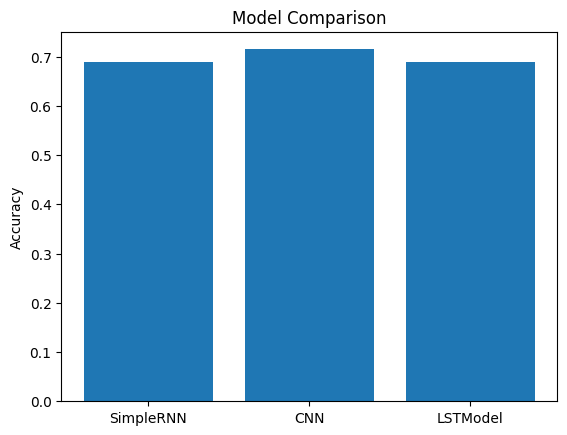

In [48]:
# Compare results
plt.bar(accuracies.keys(), accuracies.values())
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()


## URBAN SOUND DATASET

In [49]:
data=pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
data

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


## Question 1 Explore Dataset

In [50]:
data.shape

(8732, 8)

In [51]:
# different class
value_counts=data['class'].value_counts()
value_counts

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

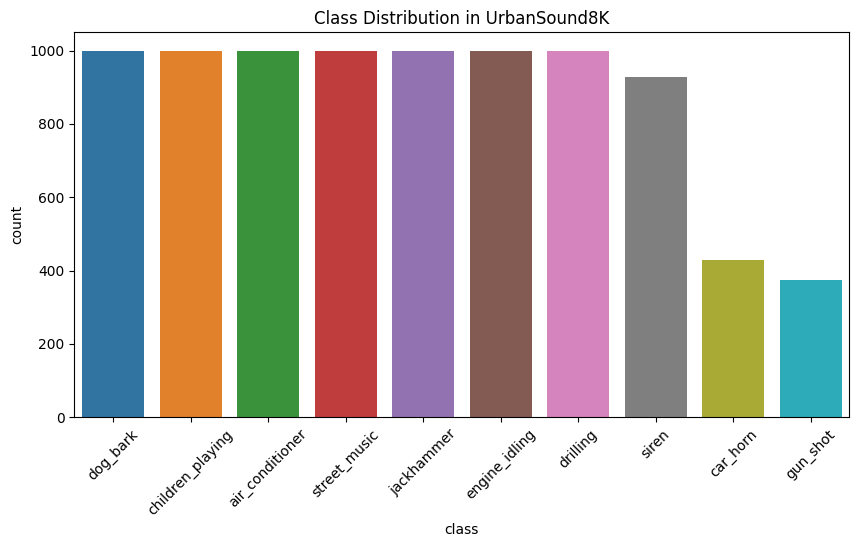

In [52]:
plt.figure(figsize=(10, 5))
sns.countplot(x='class', data=data, order=data['class'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Class Distribution in UrbanSound8K")
plt.show()

## Question 2  Provide some samples of Spectrogram of sound signals

In [53]:
def plot_spectrogram(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title("Mel Spectrogram")
    plt.show()

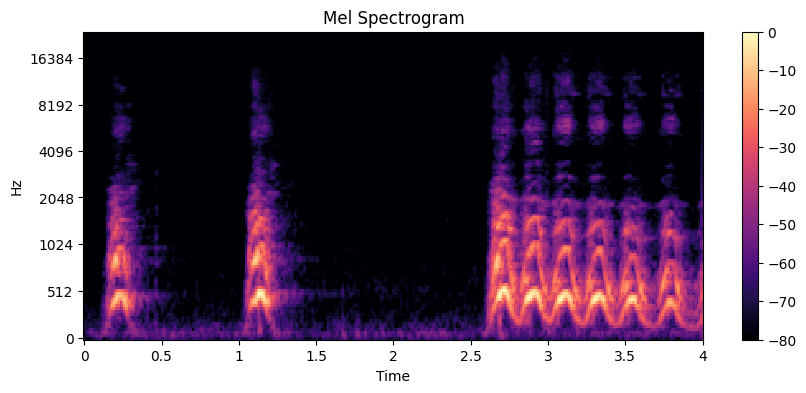

In [54]:
plot_spectrogram("/kaggle/input/urbansound8k/fold1/101415-3-0-2.wav")

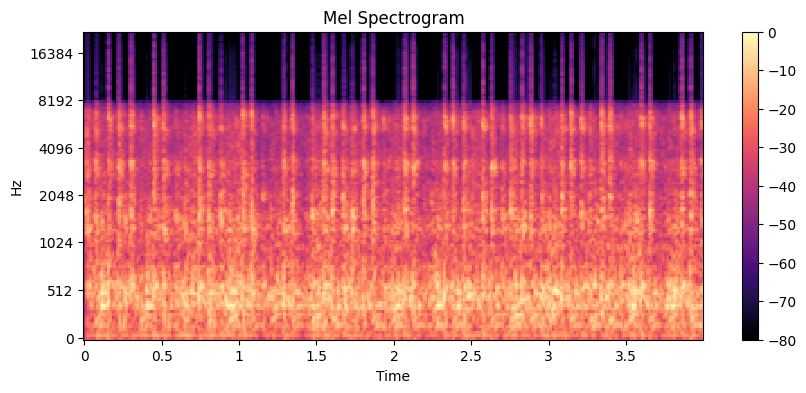

In [55]:
plot_spectrogram("/kaggle/input/urbansound8k/fold7/39857-5-0-0.wav")

## Quesrion 3 Provide some samples of MFCC of sound signals.

In [56]:
# Function to plot MFCCs
def plot_mfcc(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', cmap='coolwarm')
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()


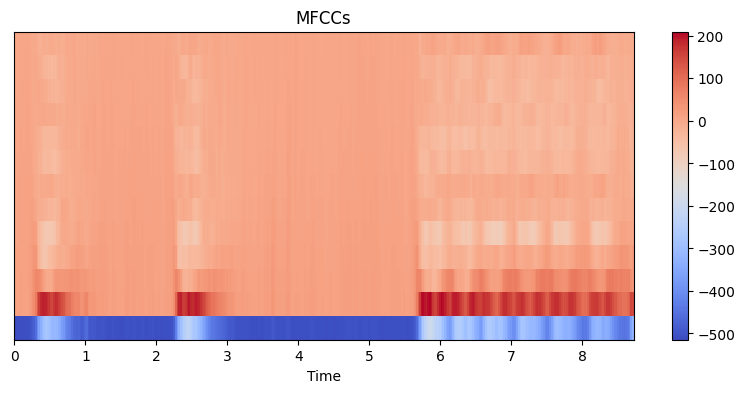

In [57]:
plot_mfcc("/kaggle/input/urbansound8k/fold1/101415-3-0-2.wav")

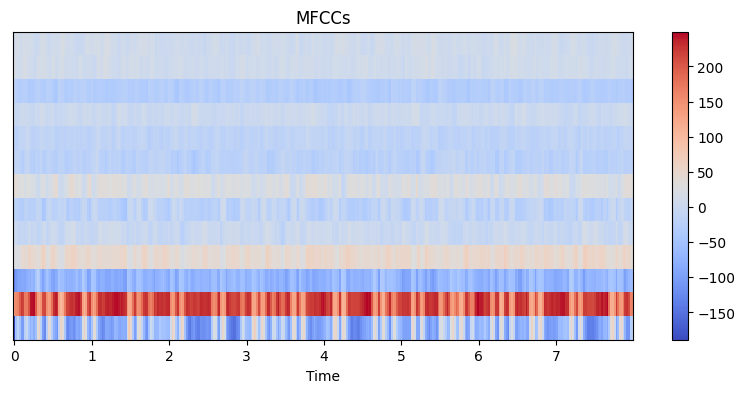

In [58]:
plot_mfcc("/kaggle/input/urbansound8k/fold7/39857-5-0-0.wav")

## Question 4 Provide three different models and compare performance

In [59]:
# Prepare file paths and labels
def prepare_data(root_dir, metadata_file):
    file_paths = []
    labels = []
    
    # Read metadata file
    with open(metadata_file, 'r') as f:
        lines = f.readlines()

    
    for line in lines[1:]: 
        parts = line.strip().split(',')
        file_name = parts[0]
        label = int(parts[6])
        
        # Construct the full file path
        file_path = os.path.join(root_dir, 'fold' + parts[5], file_name)
        
        file_paths.append(file_path)
        labels.append(label)

    dd = pd.DataFrame()
    dd['file_path']=file_paths
    dd['labels']=labels
        
    return dd

In [60]:
# Path to the dataset and metadata
root_dir = '/kaggle/input/urbansound8k/'
metadata_file = os.path.join(root_dir, 'UrbanSound8K.csv')

# Prepare file paths and labels
df= prepare_data(root_dir, metadata_file)
df.head()

,file_path,labels
0,/kaggle/input/urbansound8k/fold5/100032-3-0-0.wav,3
1,/kaggle/input/urbansound8k/fold5/100263-2-0-11...,2
2,/kaggle/input/urbansound8k/fold5/100263-2-0-12...,2
3,/kaggle/input/urbansound8k/fold5/100263-2-0-12...,2
4,/kaggle/input/urbansound8k/fold5/100263-2-0-13...,2


In [61]:

from tqdm import tqdm
# Function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=20):
    try:
        y, sr = librosa.load(file_path)  
        mfcc = librosa.feature.mfcc(y=y,  n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)  
        return mfcc_mean
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  

data_list = []

# Process each audio file
for _, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row["file_path"]   
    label = row["labels"]  

    mfcc_features = extract_mfcc(file_path)
    
    if mfcc_features is not None:
        data_list.append((*mfcc_features, label))

# Create a new DataFrame
mfcc_columns = [f"mfcc_{i}" for i in range(20)] + ["labels"]
df_mfcc = pd.DataFrame(data_list, columns=mfcc_columns)

# Save the MFCC dataset as a CSV file
df_mfcc.to_csv("urbansound8k.csv", index=False)

print("MFCC dataset saved as urbansound8k.csv")
print(df_mfcc.head())  

100%|██████████| 8732/8732 [04:23<00:00, 33.10it/s]


MFCC dataset saved as urbansound8k.csv
       mfcc_0      mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5  \
0 -211.936981   62.581215 -122.813148 -60.745293 -13.893758 -29.789835   
1 -417.005157   99.336624  -42.995583  51.073326   9.853777   7.969693   
2 -452.393158  112.362534  -37.578068  43.195866   8.631845  15.379368   
3 -406.479218   91.196602  -25.043556  42.784519  11.586844   5.054164   
4 -439.638672  103.862244  -42.658783  50.690285  12.209422  15.873465   

      mfcc_6     mfcc_7     mfcc_8    mfcc_9  ...    mfcc_11    mfcc_12  \
0  -3.978871  11.682741  12.963834  8.336420  ...  -2.996103 -12.887946   
1  11.197088   1.929118   7.030397  4.270227  ...  13.890946  -2.764493   
2  16.882149   1.233047   6.833122  3.900116  ...   8.300045   1.904138   
3  12.431632  -1.599949   6.656065  1.442354  ...  14.211005   0.434271   
4  11.729268   1.533584  11.292242  2.548622  ...  10.374461   2.101836   

    mfcc_13   mfcc_14   mfcc_15    mfcc_16   mfcc_17   mfcc_18   

In [62]:
df_mfcc["labels"].nunique()

10

In [63]:
# Extract Features (MFCC values) and Labels
feature_columns = [col for col in df_mfcc.columns if col.startswith("mfcc_")]
X = df_mfcc[feature_columns].values  
y = df_mfcc["labels"].values 

# Convert to PyTorch Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

x_train, x_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

In [64]:
class UrbanSoundDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [65]:
train_dataset=UrbanSoundDataset(x_train,y_train)
test_dataset=UrbanSoundDataset(x_test,y_test)

In [66]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [67]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch size: {data.size()}")
    break 

Batch size: torch.Size([32, 20])


In [68]:
## Simple RNN model

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(20, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    
    def forward(self, x):
        return self.fc(x)




In [69]:
class CNN(nn.Module):
    def __init__(self, n_mfcc=20, num_classes=10):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
          
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
    
        )
      
        final_length = n_mfcc // 4  
        self.fc = nn.Linear(64 * final_length, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.conv(x)    
        x = x.view(x.size(0), -1)  
        return self.fc(x)


In [70]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=128, num_classes=10):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        x = x.unsqueeze(1) 
        
        _, (h_n, _) = self.lstm(x)
        
        h = h_n[-1] 

        out = self.fc(h) 
        return out


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [72]:
model=SimpleNN()
model.to(device)
epochs=25
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [73]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for x_batch, y_batch in progress_bar:
        # Move data to GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update loss
        running_loss += loss.detach().item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")





Epoch 1/25: 100%|██████████| 219/219 [00:00<00:00, 554.29it/s]


Epoch 1/25, Loss: 1.6485


Epoch 2/25: 100%|██████████| 219/219 [00:00<00:00, 565.06it/s]


Epoch 2/25, Loss: 1.2243


Epoch 3/25: 100%|██████████| 219/219 [00:00<00:00, 544.28it/s]


Epoch 3/25, Loss: 1.0652


Epoch 4/25: 100%|██████████| 219/219 [00:00<00:00, 564.72it/s]


Epoch 4/25, Loss: 0.9197


Epoch 5/25: 100%|██████████| 219/219 [00:00<00:00, 588.17it/s]


Epoch 5/25, Loss: 0.8258


Epoch 6/25: 100%|██████████| 219/219 [00:00<00:00, 574.97it/s]


Epoch 6/25, Loss: 0.7309


Epoch 7/25: 100%|██████████| 219/219 [00:00<00:00, 563.52it/s]


Epoch 7/25, Loss: 0.6371


Epoch 8/25: 100%|██████████| 219/219 [00:00<00:00, 552.85it/s]


Epoch 8/25, Loss: 0.5722


Epoch 9/25: 100%|██████████| 219/219 [00:00<00:00, 553.88it/s]


Epoch 9/25, Loss: 0.5079


Epoch 10/25: 100%|██████████| 219/219 [00:00<00:00, 567.05it/s]


Epoch 10/25, Loss: 0.4603


Epoch 11/25: 100%|██████████| 219/219 [00:00<00:00, 574.80it/s]


Epoch 11/25, Loss: 0.4187


Epoch 12/25: 100%|██████████| 219/219 [00:00<00:00, 588.91it/s]


Epoch 12/25, Loss: 0.3922


Epoch 13/25: 100%|██████████| 219/219 [00:00<00:00, 543.88it/s]


Epoch 13/25, Loss: 0.3577


Epoch 14/25: 100%|██████████| 219/219 [00:00<00:00, 582.97it/s]


Epoch 14/25, Loss: 0.3228


Epoch 15/25: 100%|██████████| 219/219 [00:00<00:00, 588.75it/s]


Epoch 15/25, Loss: 0.2988


Epoch 16/25: 100%|██████████| 219/219 [00:00<00:00, 577.92it/s]


Epoch 16/25, Loss: 0.2647


Epoch 17/25: 100%|██████████| 219/219 [00:00<00:00, 585.65it/s]


Epoch 17/25, Loss: 0.2675


Epoch 18/25: 100%|██████████| 219/219 [00:00<00:00, 588.46it/s]


Epoch 18/25, Loss: 0.2224


Epoch 19/25: 100%|██████████| 219/219 [00:00<00:00, 585.27it/s]


Epoch 19/25, Loss: 0.1977


Epoch 20/25: 100%|██████████| 219/219 [00:00<00:00, 589.17it/s]


Epoch 20/25, Loss: 0.1933


Epoch 21/25: 100%|██████████| 219/219 [00:00<00:00, 602.17it/s]


Epoch 21/25, Loss: 0.1938


Epoch 22/25: 100%|██████████| 219/219 [00:00<00:00, 585.69it/s]


Epoch 22/25, Loss: 0.2104


Epoch 23/25: 100%|██████████| 219/219 [00:00<00:00, 596.18it/s]


Epoch 23/25, Loss: 0.1733


Epoch 24/25: 100%|██████████| 219/219 [00:00<00:00, 578.27it/s]


Epoch 24/25, Loss: 0.1469


Epoch 25/25: 100%|██████████| 219/219 [00:00<00:00, 583.72it/s]

Epoch 25/25, Loss: 0.1264


In [74]:
# Evaluate
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        y_preds.extend(predicted.cpu().numpy())
        y_trues.extend(y_batch.cpu().numpy())

accuracy = accuracy_score(y_trues, y_preds)
accuracies={}
accuracies['SimpleNN']=accuracy
print(f"Model Accuracy: {accuracy:.4f}")


Model Accuracy: 0.8678


In [75]:
model=CNN()
model.to(device)
epochs=25
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [76]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for x_batch, y_batch in progress_bar:
        # Move data to GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update loss
        running_loss += loss.detach().item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/25: 100%|██████████| 219/219 [00:00<00:00, 475.12it/s]


Epoch 1/25, Loss: 1.8727


Epoch 2/25: 100%|██████████| 219/219 [00:00<00:00, 505.59it/s]


Epoch 2/25, Loss: 1.2707


Epoch 3/25: 100%|██████████| 219/219 [00:00<00:00, 514.14it/s]


Epoch 3/25, Loss: 1.1030


Epoch 4/25: 100%|██████████| 219/219 [00:00<00:00, 521.17it/s]


Epoch 4/25, Loss: 0.9810


Epoch 5/25: 100%|██████████| 219/219 [00:00<00:00, 520.75it/s]


Epoch 5/25, Loss: 0.9022


Epoch 6/25: 100%|██████████| 219/219 [00:00<00:00, 501.31it/s]


Epoch 6/25, Loss: 0.8280


Epoch 7/25: 100%|██████████| 219/219 [00:00<00:00, 510.52it/s]


Epoch 7/25, Loss: 0.7774


Epoch 8/25: 100%|██████████| 219/219 [00:00<00:00, 492.08it/s]


Epoch 8/25, Loss: 0.7440


Epoch 9/25: 100%|██████████| 219/219 [00:00<00:00, 494.45it/s]


Epoch 9/25, Loss: 0.6861


Epoch 10/25: 100%|██████████| 219/219 [00:00<00:00, 496.13it/s]


Epoch 10/25, Loss: 0.6494


Epoch 11/25: 100%|██████████| 219/219 [00:00<00:00, 498.37it/s]


Epoch 11/25, Loss: 0.6294


Epoch 12/25: 100%|██████████| 219/219 [00:00<00:00, 492.29it/s]


Epoch 12/25, Loss: 0.6030


Epoch 13/25: 100%|██████████| 219/219 [00:00<00:00, 502.17it/s]


Epoch 13/25, Loss: 0.5792


Epoch 14/25: 100%|██████████| 219/219 [00:00<00:00, 506.12it/s]


Epoch 14/25, Loss: 0.5435


Epoch 15/25: 100%|██████████| 219/219 [00:00<00:00, 497.77it/s]


Epoch 15/25, Loss: 0.5341


Epoch 16/25: 100%|██████████| 219/219 [00:00<00:00, 511.75it/s]


Epoch 16/25, Loss: 0.5151


Epoch 17/25: 100%|██████████| 219/219 [00:00<00:00, 497.99it/s]


Epoch 17/25, Loss: 0.4927


Epoch 18/25: 100%|██████████| 219/219 [00:00<00:00, 511.14it/s]


Epoch 18/25, Loss: 0.4753


Epoch 19/25: 100%|██████████| 219/219 [00:00<00:00, 505.12it/s]


Epoch 19/25, Loss: 0.4616


Epoch 20/25: 100%|██████████| 219/219 [00:00<00:00, 507.62it/s]


Epoch 20/25, Loss: 0.4534


Epoch 21/25: 100%|██████████| 219/219 [00:00<00:00, 503.39it/s]


Epoch 21/25, Loss: 0.4255


Epoch 22/25: 100%|██████████| 219/219 [00:00<00:00, 509.66it/s]


Epoch 22/25, Loss: 0.4296


Epoch 23/25: 100%|██████████| 219/219 [00:00<00:00, 474.29it/s]


Epoch 23/25, Loss: 0.4105


Epoch 24/25: 100%|██████████| 219/219 [00:00<00:00, 514.61it/s]


Epoch 24/25, Loss: 0.3995


Epoch 25/25: 100%|██████████| 219/219 [00:00<00:00, 505.36it/s]

Epoch 25/25, Loss: 0.4052


In [77]:
# Evaluate
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        y_preds.extend(predicted.cpu().numpy())
        y_trues.extend(y_batch.cpu().numpy())

accuracy = accuracy_score(y_trues, y_preds)
accuracies['CNN']=accuracy
print(f"Model Accuracy: {accuracy:.4f}")


Model Accuracy: 0.7831


In [78]:
model=LSTMModel()
model.to(device)
epochs=25
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for x_batch, y_batch in progress_bar:
        # Move data to GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update loss
        running_loss += loss.detach().item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/25: 100%|██████████| 219/219 [00:00<00:00, 476.22it/s]


Epoch 1/25, Loss: 1.7578


Epoch 2/25: 100%|██████████| 219/219 [00:00<00:00, 489.23it/s]


Epoch 2/25, Loss: 1.2580


Epoch 3/25: 100%|██████████| 219/219 [00:00<00:00, 485.64it/s]


Epoch 3/25, Loss: 1.0613


Epoch 4/25: 100%|██████████| 219/219 [00:00<00:00, 471.00it/s]


Epoch 4/25, Loss: 0.9341


Epoch 5/25: 100%|██████████| 219/219 [00:00<00:00, 474.49it/s]


Epoch 5/25, Loss: 0.8401


Epoch 6/25: 100%|██████████| 219/219 [00:00<00:00, 489.18it/s]


Epoch 6/25, Loss: 0.7637


Epoch 7/25: 100%|██████████| 219/219 [00:00<00:00, 478.89it/s]


Epoch 7/25, Loss: 0.7019


Epoch 8/25: 100%|██████████| 219/219 [00:00<00:00, 475.90it/s]


Epoch 8/25, Loss: 0.6589


Epoch 9/25: 100%|██████████| 219/219 [00:00<00:00, 480.13it/s]


Epoch 9/25, Loss: 0.6142


Epoch 10/25: 100%|██████████| 219/219 [00:00<00:00, 409.50it/s]


Epoch 10/25, Loss: 0.5681


Epoch 11/25: 100%|██████████| 219/219 [00:00<00:00, 437.43it/s]


Epoch 11/25, Loss: 0.5401


Epoch 12/25: 100%|██████████| 219/219 [00:00<00:00, 434.77it/s]


Epoch 12/25, Loss: 0.5098


Epoch 13/25: 100%|██████████| 219/219 [00:00<00:00, 478.25it/s]


Epoch 13/25, Loss: 0.4816


Epoch 14/25: 100%|██████████| 219/219 [00:00<00:00, 478.28it/s]


Epoch 14/25, Loss: 0.4571


Epoch 15/25: 100%|██████████| 219/219 [00:00<00:00, 471.19it/s]


Epoch 15/25, Loss: 0.4380


Epoch 16/25: 100%|██████████| 219/219 [00:00<00:00, 471.67it/s]


Epoch 16/25, Loss: 0.4146


Epoch 17/25: 100%|██████████| 219/219 [00:00<00:00, 460.62it/s]


Epoch 17/25, Loss: 0.3971


Epoch 18/25: 100%|██████████| 219/219 [00:00<00:00, 469.84it/s]


Epoch 18/25, Loss: 0.3799


Epoch 19/25: 100%|██████████| 219/219 [00:00<00:00, 489.34it/s]


Epoch 19/25, Loss: 0.3687


Epoch 20/25: 100%|██████████| 219/219 [00:00<00:00, 484.13it/s]


Epoch 20/25, Loss: 0.3530


Epoch 21/25: 100%|██████████| 219/219 [00:00<00:00, 491.42it/s]


Epoch 21/25, Loss: 0.3377


Epoch 22/25: 100%|██████████| 219/219 [00:00<00:00, 490.67it/s]


Epoch 22/25, Loss: 0.3271


Epoch 23/25: 100%|██████████| 219/219 [00:00<00:00, 481.43it/s]


Epoch 23/25, Loss: 0.3121


Epoch 24/25: 100%|██████████| 219/219 [00:00<00:00, 473.91it/s]


Epoch 24/25, Loss: 0.3052


Epoch 25/25: 100%|██████████| 219/219 [00:00<00:00, 463.77it/s]

Epoch 25/25, Loss: 0.2916


In [80]:
# Evaluate
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        y_preds.extend(predicted.cpu().numpy())
        y_trues.extend(y_batch.cpu().numpy())

accuracy = accuracy_score(y_trues, y_preds)
accuracies['LSTM']=accuracy
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8409


## Question 5. Which feature+model combination is working the best?


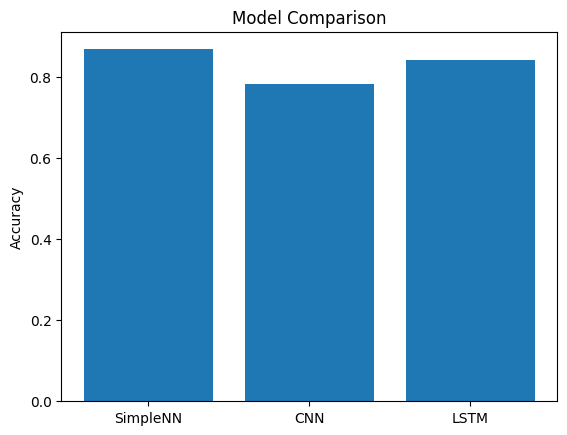

In [81]:
# Compare results
plt.bar(accuracies.keys(), accuracies.values())
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()


#### LSTM model appears to be the most effective combination of feature and model.